# Assignment 4 - Non Personalized Recommendation Engine
---
Nicholas Belev

Professor Santiago Gil Begue

Chatbots and Recommendation Engines

23 February 2025

---

## Using a Feedback Dataset on Cooking Recipes
---

### Analyzing the Recipe Reviews Dataset

Getting familiar with the dataset, its properties, facts extracted as metadata, and helpful visualizations

In [ ]:
def setup_kaggle():
    from google.colab import files
    uploaded = files.upload()  # Kaggle token to access API
    !chmod 600 kaggle.json
    %mkdir -p /root/.kaggle/
    %mv kaggle.json /root/.kaggle/

# Authenticate via uploading your token
setup_kaggle()

Saving kaggle.json to kaggle.json


In [ ]:
!pip install -q kaggle
import kaggle
kaggle.api.authenticate()

# Data Science and visualization suite of libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Ensures that when we use random for stochastic simulations,
# it will result in the "same" outcome regardless of what device this code is run on
import random
my_seed = 1234
random.seed(my_seed)
np.random.seed(my_seed)

In [ ]:
!pip install -q kagglehub
import kagglehub

# The dataset on Kaggle, extract locally
path = kagglehub.dataset_download("joebeachcapital/recipe-reviews-and-user-feedback-dataset")
print("Path to dataset files:", path)

100%|██████████| 2.07M/2.07M [00:00<00:00, 94.2MB/s]

Extracting files...
Path to dataset files: /root/.cache/kagglehub/datasets/joebeachcapital/recipe-reviews-and-user-feedback-dataset/versions/1


In [ ]:
!ls /root/.cache/kagglehub/datasets/joebeachcapital/recipe-reviews-and-user-feedback-dataset/versions/1

'Recipe Reviews and User Feedback Dataset.csv'


In [ ]:
 # The data is called: 'Recipe Reviews and User Feedback Dataset.csv'
csv_file = "Recipe Reviews and User Feedback Dataset.csv"

# Load the CSV file into a DataFrame
df = pd.read_csv(f"{path}/{csv_file}")
print("DataFrame shape:", df.shape)
df.head()

DataFrame shape: (18182, 15)


,Unnamed: 0,recipe_number,recipe_code,recipe_name,comment_id,user_id,user_name,user_reputation,created_at,reply_count,thumbs_up,thumbs_down,stars,best_score,text
0,0,1,14299,Creamy White Chili,sp_aUSaElGf_14299_c_2G3aneMRgRMZwXqIHmSdXSG1hEM,u_9iFLIhMa8QaG,Jeri326,1,1665619889,0,0,0,5,527,"I tweaked it a little, removed onions because ..."
1,1,1,14299,Creamy White Chili,sp_aUSaElGf_14299_c_2FsPC83HtzCsQAtOxlbL6RcaPbY,u_Lu6p25tmE77j,Mark467,50,1665277687,0,7,0,5,724,Bush used to have a white chili bean and it ma...
2,2,1,14299,Creamy White Chili,sp_aUSaElGf_14299_c_2FPrSGyTv7PQkZq37j92r9mYGkP,u_s0LwgpZ8Jsqq,Barbara566,10,1664404557,0,3,0,5,710,I have a very complicated white chicken chili ...
3,3,1,14299,Creamy White Chili,sp_aUSaElGf_14299_c_2DzdSIgV9qNiuBaLoZ7JQaartoC,u_fqrybAdYjgjG,jeansch123,1,1661787808,2,2,0,0,581,"In your introduction, you mentioned cream chee..."
4,4,1,14299,Creamy White Chili,sp_aUSaElGf_14299_c_2DtZJuRQYeTFwXBoZRfRhBPEXjI,u_XXWKwVhKZD69,camper77,10,1664913823,1,7,0,0,820,Wonderful! I made this for a &#34;Chili/Stew&#...


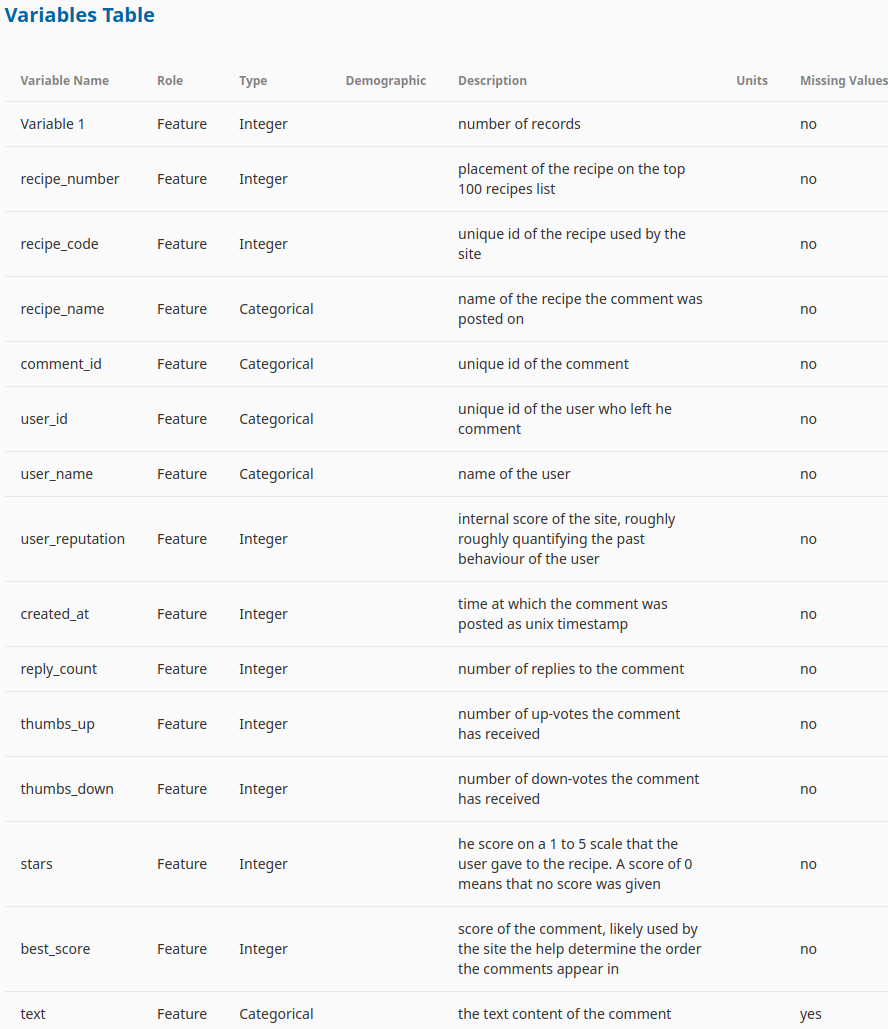

In [ ]:
# Filter out ratings with 0 stars (usually people who just left comments)
df_filtered = df[df['stars'] != 0] # Will be convenient later on

# Metadata on the dataframe we will use for our recommender

print(f"{df['user_id'].nunique()} unique users comprise this data.")
print(f"There average user has a reputation of {df['user_reputation'].mean()}.")
print(f"This dataset contains {df.shape[0]} total ratings")
print(f"This data consists of {df['recipe_code'].nunique()} different recipes.")
print(f"The average recipe rating is {sum(stars for stars in df_filtered['stars']) / df_filtered.shape[0]}") # Ignore 0 stars, as this means no star rating was given


13812 unique users comprise this data.
There average user has a reputation of 2.1596084039159607.
This dataset contains 18182 total ratings
This data consists of 100 different recipes.
The average recipe rating is 4.730013344656072


Note that this dataset is clearly large with tens of thousands of reviews.  Furthermore a select few users have extremely high reputations meaning they interact with the reviewing mechanism a high amount, however the vast majority of people have very low reputations and have only reviewed a handful of items.

There is also a reasonable selection of recipes (100) making this dataset ideal for a recommendation engine that will have substantial data on a sizeable set of items, to make inferences on a large set of users.

Also, it seems people who rate recipes are almost "too nice", or at least the bias of this dataset is towards the 5 star category--maybe all the recipes are indeed that delicious.  Aside, the distribution is heavily left skewed, discounting the users that left comments but no rating-review.

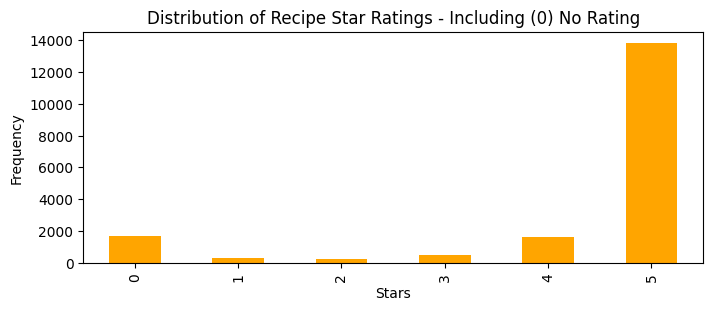

In [ ]:
plt.subplots(figsize=(8,3))
df.groupby('stars').size().plot(kind='bar', color='orange');

plt.xlabel("Stars")
plt.ylabel("Frequency")
plt.title("Distribution of Recipe Star Ratings - Including (0) No Rating")
plt.show()

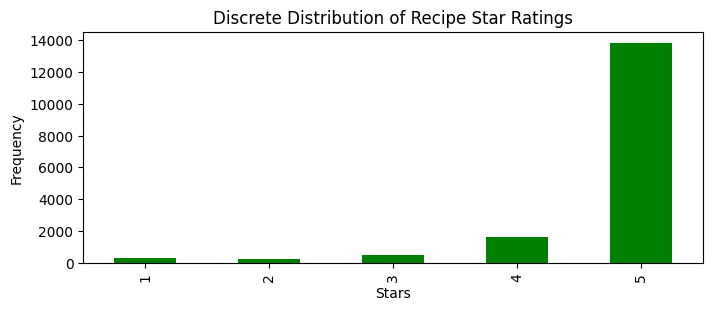

The ratings mean is 4.73 and standard deviation is 0.7381


In [ ]:
plt.figure(figsize=(8, 3))
df_filtered.groupby('stars').size().plot(kind='bar', color='green')

plt.xlabel("Stars")
plt.ylabel("Frequency")
plt.title("Discrete Distribution of Recipe Star Ratings")
plt.show()

mean = df_filtered['stars'].mean()
std = df_filtered['stars'].std()
print(f'The ratings mean is {round(mean, 2)} and standard deviation is {round(std, 4)}')

### Developing a Random Recommender

Note the random recommender, though naive, can be improved by sampling from a distribution close to the discrete distribution we see that the reviews in our dataset follows, as we assume that the underlying population of users of this recipe platform conform to this same distribution.

Note that a normal distribution is a poor fit for the shape of this data, instead we should opt for a gamma distribution that we cut off at higher values which will exhibit the bias towards higher frequency of 5 star reviews with a long tapered left-side tail (left skew), that will fit the data better than a Gaussian cruve.

We then "guess" the rating for an arbitrary user and item by "predicting" it using this probability distribution.

In [ ]:
# MLE's / unbiased estimators for the population parameters based on the dataset sample
k = (mean / std) ** 2  # shape
theta = (std ** 2) / mean  # scale

def random_predict(user, item):
    """Generates a random rating based on a right-skewed Gamma distribution."""
    raw_prediction = np.random.gamma(k, theta)  # Sample from gamma, (note could theoretically be outside of the valid 1-5 star range;
                                        # and will almost never be an integer)
    # conform to the 1 - 5 star range:
    return np.clip(raw_prediction, 1, 5)

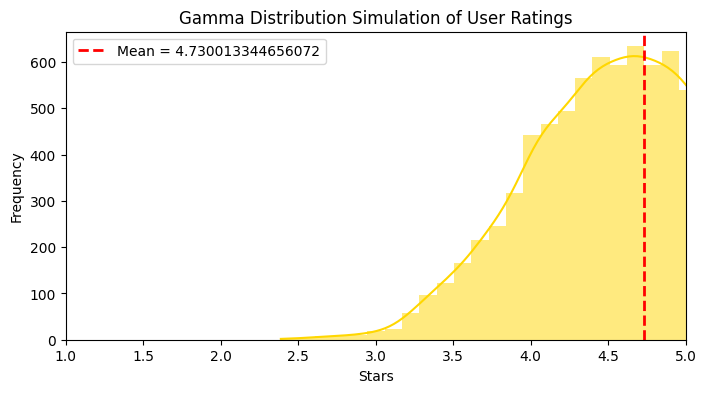

In [ ]:
# A histogram approximation of the real Gamma distribution of user ratings matching our dataset parameters

samples = np.random.gamma(k, theta, size=10000) # A sample size of 10000 user reviews, model with the population parameters calculated in the cell above

# Visualizing the histogram, to compare its fit with the discrete distribution of ratings from the original dataset
plt.figure(figsize=(8, 4))
sns.histplot(samples, bins=50, kde=True, color="gold", edgecolor="None")
plt.axvline(mean, color='red', linestyle='dashed', linewidth=2, label=f"Mean = {mean}")
plt.xlim(1, 5)
plt.xlabel("Stars")
plt.ylabel("Frequency")
plt.title("Gamma Distribution Simulation of User Ratings")
plt.legend()
plt.show()

In [ ]:
# Testing the random predictor knowing that neither users nor items are considered for the "scoring"

print(random_predict(user=1, item=3))
print(random_predict(user=1, item=3))

print(random_predict(user=55, item=88))

print(random_predict(user=7893, item=1))


5.0
4.106129721849072
5.0
5.0


Note from above the futility of specifying a user and item, because they do not factor into sampling from a predefined distribution and are dummy parameters to the `random_predict` function

The naivety is apparent as this method does not adjust for the user and just quantifies based on the population, a reasonable score that a person picked at random who follows a recipe (also at random), would like.

Oddly enough, for the majority of users sampled in this dataset, and the majority of recipes, this recommender might not yield poor results due to the sheer lack of negative ratings and overwhelmingly positive reviews of most recipes.

In [ ]:
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(df_filtered, test_size=0.2, random_state=42)

print("Train set size:", len(train_df))
print("Test set size:", len(test_df))

Train set size: 13188
Test set size: 3298


Train-Test split is performed to ensure no data leakage, as a formality, though with a random recommender this is less of a concern as the rating itself is a random variable, that isn't personalized.

In [ ]:
# Estimates for the test population users
num_test_samples = len(test_df)
random_predictions_test = np.random.gamma(k, theta, size=num_test_samples)
random_predictions_test = np.clip(random_predictions_test, 1, 5)

random_predictions_df = pd.DataFrame({
    'user_id': test_df['user_id'],
    'recipe_code': test_df['recipe_code'],
    'true_rating': test_df['stars'],
    'predicted_rating': random_predictions_test
})

random_predictions_df.head(10)

,user_id,recipe_code,true_rating,predicted_rating
9265,u_1oKVxxovcGhELPvDmJnOecjjDF7,32535,5,5.000000
17288,u_1oKVbwzq1y9kq4evab34zQ2l8bU,141947,5,4.896818
5593,u_1oKXBn6eCWWpqBmoSRgdU78NVdN,10252,2,5.000000
8285,u_1oKYRdmnEzWiVanwDZ1XScoDE8X,12734,4,4.384885
17775,u_1oKZEGCVLu3hfbi2HOj995DaStM,34347,5,5.000000
15317,u_1oKYywBLuDqjGHm5RT5mNQke7It,46655,5,4.027362
3208,u_1oKdFg8AasoZW2gbYhc84SGEpmP,6086,5,4.655944
2079,u_1oKVia0KdiFVC7qjZo6iDceDZOc,17826,5,4.470223
6917,u_1oKXp8IRkpVijOqSIprZpae6omv,33206,5,5.000000
4911,u_1oKcxwNzXkFygPv4Th72n0Y5lvL,32480,5,5.000000


<ipython-input-14-b3812cad4e3f>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(


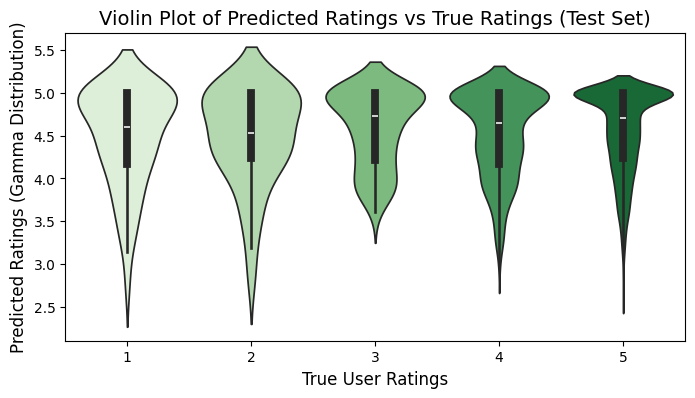

In [ ]:
fig, ax = plt.subplots(figsize=(8, 4))
sns.violinplot(
    data=random_predictions_df,
    x="true_rating",
    y="predicted_rating",
    palette="Greens"
)

ax.set_xlabel("True User Ratings", fontsize=12)
ax.set_ylabel("Predicted Ratings (Gamma Distribution)", fontsize=12)
ax.set_title("Violin Plot of Predicted Ratings vs True Ratings (Test Set)", fontsize=14)

plt.show()

To interpret this plot, we look first at the x-axis, the true user ratings (1 to 5 stars).  For each of these ratings, we have a corresponding distribution, visualized on the y-axis.  These distributions are histograms which are constructed as follows: for every instance of an 'x'-star rating that was actually given to a recipe, what 'y'-star prediction was produced?  

Using the answer to this question, a point is marked on the histogram, this is repeated across all true ratings and their corresponding prediction for users and recipes.

The result is intuitive, a left skew for all the histograms, reflective of the distribution that is used to guess / predict a recipe rating (which we deduced from the actual distribution of stars from the dataset).

There is some variation between the 1, 2, 3, 4, and 5 star "violins" but this can be attributed to sample randomness, especially since the volume of 5 star true ratings dominates the other 4 possible ratings combined so had more data to approach its "true" distribution (via the law of large numbers).

Since the mean is very close to 5 stars, the included box plot does not have a right whisker that extends beyond 5 stars.  Thus, the box encloses all datapoints to the right of the mean (none of which can have more than 5 stars).

### Developing a Popular Recommender

A popularity based recommender that determines which items are the most observed / have the best overall score: for instance, via the mean of ratings assigned by all its users.  Specifically, recipes with higher stars ought to be prioritized over poorly-scored recipes that are less likely to be preferred by the average user.

In [ ]:
train_df, test_df = train_test_split(df_filtered, test_size=0.2, random_state=42)

print("Train set size:", len(train_df))
print("Test set size:", len(test_df))

Train set size: 13188
Test set size: 3298


In [ ]:
popularity_tool_df = (
    train_df
    .groupby('recipe_code')
    .agg({'stars': 'mean'})   # In-place calculate rating
    .rename(columns={'stars': 'mean_stars'})
)

popularity_tool_df.head(10)

,mean_stars
recipe_code,
386,4.528736
414,4.760331
957,4.732026
1063,4.789062
1081,4.633663
1152,4.426087
1196,4.740157
1324,4.604396
1693,4.722892


Here, the popular rating predictor emphasizes its lack of personalization, by only considering the population's consensus on whether an item (recipe) is well-liked, as opposed to accounting for individual preferences.  In this sense a popular recommender is also naive.

In [ ]:
# Step 3: Define the predictor
train_global_mean = train_df['stars'].mean()

def popular_predict(recipe_code):
    """
    Returns the mean rating of the recipe_code based on the TRAIN SET.
    If the recipe_code wasn't in the train set, return a fallback (global mean).
    """
    if recipe_code in popularity_tool_df.index:
        return popularity_tool_df.loc[recipe_code, 'mean_stars']
    else:
        # if the recipe doesn't exist in the training set, avoid error, unideal but better than crashing
        return train_global_mean


In [ ]:
# Predict on the test set
popular_predictions_test = [popular_predict(item) for item in test_df['recipe_code'].values]

# Build a DataFrame with test predictions
popular_predictions_df = pd.DataFrame({
    'user_id':        test_df['user_id'],
    'recipe_code':    test_df['recipe_code'],
    'recipe_name':    test_df.get('recipe_name', None),
    'true_rating':    test_df['stars'],
    'predicted_rating': popular_predictions_test
})

popular_predictions_df.head()

,user_id,recipe_code,recipe_name,true_rating,predicted_rating
9265,u_1oKVxxovcGhELPvDmJnOecjjDF7,32535,Creamy Grape Salad,5,4.809160
17288,u_1oKVbwzq1y9kq4evab34zQ2l8bU,141947,Ham and Swiss Sliders,5,4.793478
5593,u_1oKXBn6eCWWpqBmoSRgdU78NVdN,10252,Li’l Cheddar Meat Loaves,2,4.759036
8285,u_1oKYRdmnEzWiVanwDZ1XScoDE8X,12734,Cheesy Ham Chowder,4,4.801370
17775,u_1oKZEGCVLu3hfbi2HOj995DaStM,34347,Lime Chicken Tacos,5,4.500000


<ipython-input-19-cd9b557d6cb7>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(


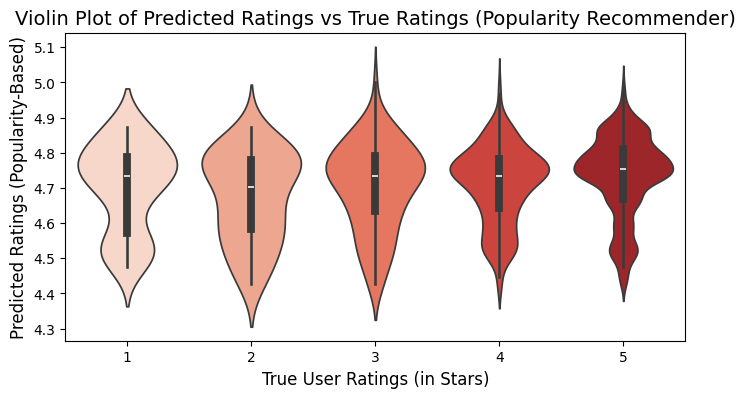

In [ ]:
fig, ax = plt.subplots(figsize=(8, 4))
sns.violinplot(
    data=popular_predictions_df,
    x="true_rating",
    y="predicted_rating",
    palette="Reds"
)

ax.set_xlabel("True User Ratings (in Stars)", fontsize=12)
ax.set_ylabel("Predicted Ratings (Popularity-Based)", fontsize=12)
ax.set_title("Violin Plot of Predicted Ratings vs True Ratings (Popularity Recommender)", fontsize=14)

plt.show()

Clearly, the violin plot demonstrates that there is a higher correlation between the mean of the predicted rating distribution and the actual 1 through 5 -star ratings that users gave to corresponding items.  There is a consistent updwards trend for all the means of each histogram (although their ranges are between roughly 4.4 - 5.0, so is not reflective of the true range (1 - 5).

Observedly, the distribution tightens--the variance constricts--as we observe the 1 star distribution, as compared to the 2, 3, 4, and lastly, 5 star distribution, which has the lowest variance, and centers very closely around its predicted mean (4.75 approx.).  This is because in a dataset of already very many 5-star reviews, the items that are actually 5-star tend to get overwhelmingly many 5-star reviews.

### Bonus - Baysian Average Popular Recommender



Intended to adjust for recipes that have extremely few reviews, although these few reviews may rate the recipe highly.  The intuition is that a few reviews are not as well informed and do not indicate consistency nearly as much as an recipe with a similarly high average score and, for instance, a few hundred reviews.

In [ ]:
# Split the dataset into train (80%) and test (20%)
train_df, test_df = train_test_split(df_filtered, test_size=0.2, random_state=42)

print("Train set size:", len(train_df))
print("Test set size:", len(test_df))


Train set size: 13188
Test set size: 3298


This implements the Baysian Average formula as instructed on the site:

https://www.algolia.com/doc/guides/managing-results/must-do/custom-ranking/how-to/bayesian-average/


In [ ]:
# Again start out like a popular recommender, ignoring users for the "scoring"
bayesian_recipe_df = (
    train_df
    .groupby('recipe_code')
    .agg({'stars': ['mean', 'count']}) # Save both the score and the number of reviews
    .pipe(lambda x: x.set_axis(x.columns.map('_'.join), axis=1))
    #   => e.g., columns become [stars_mean, stars_count]
)

# mean rating across all recipes (TRAIN)
global_avg_rating = train_df['stars'].mean()

# For Bayesian smoothing, we pick the median # of ratings from the TRAIN set
min_reviews_required = train_df['recipe_code'].value_counts().quantile(0.50)
# This helps to balance / smooth the Bayesian calculation,
# penalizing recipes with fewer reviews more strongly.

# Applying the Bayesian average formula
bayesian_recipe_df['bayes_adjusted_rating'] = (
    (global_avg_rating * min_reviews_required + bayesian_recipe_df['stars_mean'] * bayesian_recipe_df['stars_count'])
    / (min_reviews_required + bayesian_recipe_df['stars_count'])
)

# Sort from highest scored to lowest by Bayesian-modified rating
bayesian_recipe_df = bayesian_recipe_df.sort_values(by='bayes_adjusted_rating', ascending=False)

bayesian_recipe_df.head()


,stars_mean,stars_count,bayes_adjusted_rating
recipe_code,,,
12540,4.906810,279,4.856751
14299,4.871245,466,4.844207
39581,4.966292,89,4.835451
12259,4.928571,98,4.823281
41101,4.870647,201,4.820707


In [ ]:
# Fallback in case a recipe_code isn't in the training set
def bayesian_predict(recipe_code):
    if recipe_code in bayesian_recipe_df.index:
        return bayesian_recipe_df.loc[recipe_code, 'bayes_adjusted_rating']
    else:
        # fallback to the global average from the training data
        return global_avg_rating

In [ ]:
# Prepare the user-recipe pairs from the TEST set
user_items_to_predict_test = zip(test_df['user_id'], test_df['recipe_code'])

# For each (user, recipe) in TEST, get the Bayesian-predicted rating
bayesian_predictions_test = [
    bayesian_predict(recipe)
    for (user, recipe) in user_items_to_predict_test
]

# Create a DataFrame comparing true ratings vs. Bayesian-predicted ratings (TEST only)
bayesian_predictions_df = pd.DataFrame({
    'user_id':       test_df['user_id'],
    'recipe_code':   test_df['recipe_code'],
    # If you have 'recipe_name' in your test_df, you can include it here:
    'recipe_name':   test_df.get('recipe_name', None),
    'true_rating':   test_df['stars'],
    'predicted_rating': bayesian_predictions_test
})

bayesian_predictions_df.head()

,user_id,recipe_code,recipe_name,true_rating,predicted_rating
9265,u_1oKVxxovcGhELPvDmJnOecjjDF7,32535,Creamy Grape Salad,5,4.772580
17288,u_1oKVbwzq1y9kq4evab34zQ2l8bU,141947,Ham and Swiss Sliders,5,4.758305
5593,u_1oKXBn6eCWWpqBmoSRgdU78NVdN,10252,Li’l Cheddar Meat Loaves,2,4.746979
8285,u_1oKYRdmnEzWiVanwDZ1XScoDE8X,12734,Cheesy Ham Chowder,4,4.770272
17775,u_1oKZEGCVLu3hfbi2HOj995DaStM,34347,Lime Chicken Tacos,5,4.644042


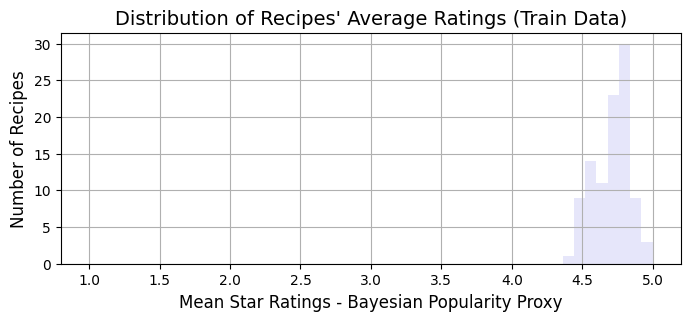

In [ ]:
plt.figure(figsize=(8, 3))
# Plot the distribution of recipe mean ratings from the TRAIN set
bayesian_recipe_df['stars_mean'].hist(bins=50, range=(1, 5), color='lavender')

plt.xlabel("Mean Star Ratings - Bayesian Popularity Proxy", fontsize=12)
plt.ylabel("Number of Recipes", fontsize=12)
plt.title("Distribution of Recipes' Average Ratings (Train Data)", fontsize=14)

plt.show()

<ipython-input-25-479163b44b32>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(


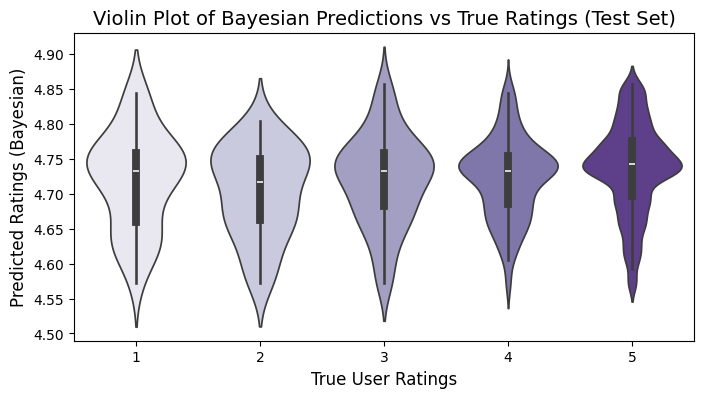

In [ ]:
fig, ax = plt.subplots(figsize=(8, 4))
sns.violinplot(
    data=bayesian_predictions_df,
    x="true_rating",
    y="predicted_rating",
    palette="Purples"
)

ax.set_xlabel("True User Ratings", fontsize=12)
ax.set_ylabel("Predicted Ratings (Bayesian)", fontsize=12)
ax.set_title("Violin Plot of Bayesian Predictions vs True Ratings (Test Set)", fontsize=14)

plt.show()

Briefly, this distribution has similar mean behavior to the Popular Recommender that did not adjust for uncertainty.  As a result of this uncertainty adjustment, these histograms have tighter, lower-variance distributions across all true ratings (1 - 5).  Moreover, the distributions are more symmetric.

This indicates that penalizing uncertainty in the form of few reviews yields a slightly better overall recommender in terms of consistency.

### Collaborative Filtering Recommender as a Baseline

In [ ]:
# There are 701 instances of users leaving duplicate reviews
duplicate_counts = df_filtered.groupby(['user_id', 'recipe_code']).size().reset_index(name='count')
duplicates = duplicate_counts[duplicate_counts['count'] > 1]
print(duplicates)

df_CF = df_filtered.drop_duplicates(subset=['user_id', 'recipe_code'], keep='first')
# It seems this dataset has the same person leaving the same review for the same recipe multiple times
# To avoid issues and duplicate errors, we drop these instances and retain the majority of our data
# Policy: keep only the first review encountered for a given 'user_id', 'recipe_code' combination.

# Filter out very sparse users
min_interactions = 5
user_counts = df_CF['user_id'].value_counts()
valid_users = user_counts[user_counts >= min_interactions].index

# Keep only rows where user_id is in valid_users
df_reduced = df_CF[df_CF['user_id'].isin(valid_users)].copy()

df_reduced.head()

                             user_id  recipe_code  count
34     u_1oKVZT7bnHOk8MH7Aom0wkTCJNo         2872      2
52     u_1oKVZTi0UOjTtdNBtFIYYHyN2x6        11588      2
72     u_1oKVZV8wblzSXpQhslDphdFqwqz        26937      4
131    u_1oKVZayWppErhTC8Zdspk9bGr7q        39334      3
155    u_1oKVZbmXe034ZVsauDi7AuMVJCI         3309      3
...                              ...          ...    ...
15324                 u_PZFRKMd4GEeR        32535      2
15434                 u_YAcwSJOH6Znt          414      2
15453                 u_ZvRwjvOokuVF        12259      2
15466                 u_aswkdKPyJQ96         9739      2
15512                 u_f09qx6gNErmR        17826      2

[612 rows x 3 columns]


,Unnamed: 0,recipe_number,recipe_code,recipe_name,comment_id,user_id,user_name,user_reputation,created_at,reply_count,thumbs_up,thumbs_down,stars,best_score,text
27,27,1,14299,Creamy White Chili,sp_aUSaElGf_14299_c_432496,u_1oKVZT7bnHOk8MH7Aom0wkTCJNo,ahmom,1,1622648873,0,4,0,5,329,EXCELLENT RECIPE!! This will be on regular rot...
31,31,1,14299,Creamy White Chili,sp_aUSaElGf_14299_c_429113,u_1oKVr0FIiKTNe84vUuYXGEKMHfD,gooch621,1,1622648882,0,3,0,5,297,Outstanding just the way it is!
56,56,1,14299,Creamy White Chili,sp_aUSaElGf_14299_c_384535,u_1oKWWgyoJAqNhh1VGGmFPp24Au9,mrscessna,1,1622718272,0,0,0,4,100,Easy and tasty!
79,79,1,14299,Creamy White Chili,sp_aUSaElGf_14299_c_424088,u_1oKVchl3LINh51liAWR6aZjJEqJ,jeanemed,20,1622718447,0,0,0,5,100,Very good. I wonder if it once had cream chees...
83,83,1,14299,Creamy White Chili,sp_aUSaElGf_14299_c_423740,u_1oKVyRJPymM0gqQgaXO2kbAAFwF,skipperstrucking,1,1622718475,0,0,0,5,100,Very good recipe. you do need to add a couple...


In [ ]:
train_df, test_df = train_test_split(df_reduced, test_size=0.2, random_state=42)

print("Train set size:", len(train_df))
print("Test set size:", len(test_df))

Train set size: 1412
Test set size: 353


In [ ]:
ui_matrix_df = train_df.pivot(
    index='user_id',
    columns='recipe_code',
    values='stars'
).fillna(0)

ui_matrix_df.head()

recipe_code,386,414,957,1063,1081,1152,1196,1324,1693,1821,...,42386,42873,43675,45495,46655,74724,82745,100276,141947,191775
user_id,,,,,,,,,,,,,,,,,,,,,
u_1oKVZPP8jYZRYPrNWRdDSTevmF4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
u_1oKVZT7bnHOk8MH7Aom0wkTCJNo,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
u_1oKVZTHTqi7N4NPqNxPS2XB2asz,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
u_1oKVZTi0UOjTtdNBtFIYYHyN2x6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
u_1oKVZUMDcz6fqhcfNkITken7Qof,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
from sklearn.metrics.pairwise import euclidean_distances

# pivot table to a NumPy array for euclidean distance
ui_matrix = ui_matrix_df.values

# user_similarity[i, j] is proxied with Euclidean distance between user i and user j
user_distance_matrix = euclidean_distances(ui_matrix)

# back to dataframe for convenience
user_distance_df = pd.DataFrame(
    user_distance_matrix,
    index=ui_matrix_df.index,
    columns=ui_matrix_df.index
)

user_distance_df.head()

user_id,u_1oKVZPP8jYZRYPrNWRdDSTevmF4,u_1oKVZT7bnHOk8MH7Aom0wkTCJNo,u_1oKVZTHTqi7N4NPqNxPS2XB2asz,u_1oKVZTi0UOjTtdNBtFIYYHyN2x6,u_1oKVZUMDcz6fqhcfNkITken7Qof,u_1oKVZagX4nkLravRce6v3sDjTYT,u_1oKVZangmN67bJNxpyD1j55VJCj,u_1oKVZaxgZr9JqCUTsowfyIT48aS,u_1oKVZayWppErhTC8Zdspk9bGr7q,u_1oKVZbcNg5NYW87grfhDXNePwbL,...,u_1oKWIHTpZVWE78BzXlFv9wIfWFR,u_1oKWL4CuzpDylhkntiO5c7Yv2Jl,u_1oKWWgyoJAqNhh1VGGmFPp24Au9,u_1oKWWvykonxY65ADfIjsEU1y3wc,u_1oKWX52FfgQlAetHgnTqZXRGn6Q,u_1oKX7cV3yzfpMU1TF6lVs1jKwlP,u_1oKXvXFcvDp4sNo04DNupOqaWWE,u_1oKbG5jvrFHeG7LCseTkgikAkwH,u_7oJ0YWDuESeV,u_Z8NvFJwDxp6D
user_id,,,,,,,,,,,,,,,,,,,,,
u_1oKVZPP8jYZRYPrNWRdDSTevmF4,0.000000,15.652476,13.820275,16.309506,15.491933,14.177447,18.466185,15.811388,17.549929,19.364917,...,14.696938,14.142136,14.422205,13.490738,14.142136,15.000000,16.309506,13.820275,16.031220,14.696938
u_1oKVZT7bnHOk8MH7Aom0wkTCJNo,15.652476,0.000000,13.638182,16.155494,13.892444,15.684387,19.646883,15.652476,18.520259,18.165902,...,14.525839,13.964240,14.247807,12.124356,15.652476,11.401754,16.155494,14.000000,14.212670,14.525839
u_1oKVZTHTqi7N4NPqNxPS2XB2asz,13.820275,13.638182,0.000000,12.529964,14.866069,13.856406,19.544820,13.820275,17.000000,16.309506,...,12.529964,13.820275,13.747727,11.090537,11.874342,12.884099,14.387495,13.490738,14.071247,12.529964
u_1oKVZTi0UOjTtdNBtFIYYHyN2x6,16.309506,16.155494,12.529964,0.000000,17.204651,16.340135,20.420578,16.309506,17.720045,17.058722,...,15.231546,16.309506,14.966630,12.569805,12.884099,15.524175,16.792856,16.031220,15.264338,15.231546
u_1oKVZUMDcz6fqhcfNkITken7Qof,15.491933,13.892444,14.866069,17.204651,0.000000,15.524175,21.702534,16.733201,18.110770,17.748239,...,15.684387,16.733201,12.884099,13.490738,15.491933,14.662878,17.204651,13.820275,16.941074,14.352700


Notice that across the diagonal, the Euclidean distance is 0 because a user is pefectly similar to themselves; some users also have given very few reviews--and the few that they have are identical so they are also considered "perfectly similar".  Obviously this is not realistic and won't yield maximal accuracy, so demonstrates the naivety of this form of CF.

In [ ]:
def get_similar_users(user_id, distance_df, knn=5):
    """
    Returns the K nearest neighbors,
    shortest Euclidean Distance => most similar users to the given user_id.
    """
    if user_id not in distance_df.index:
        return []

    # Sort via euclid distance ascending; closer = ranked more similar
    sorted_neighbors = distance_df[user_id].sort_values()

    # exclude self (distance=0), select top K
    neighbors = sorted_neighbors.index[1:knn+1]
    distances = sorted_neighbors.values[1:knn+1]

    return list(zip(neighbors, distances))

Again, the sheer amount of users who have rated the exact same item(s) with the exact same score (stars), means a lot of users have a 0 Euclidean distance from each other.

In [ ]:
# Test: Get top 5 similar users to the first user in the distance_df
user_test = user_distance_df.index[0]
neighbors = get_similar_users(user_test, user_distance_df, knn=5)

print(f"Top 5 similar users to {user_test}:")
for neighbor, dist in neighbors:
    print(f"User: {neighbor}, Euclidean Distance: {dist:.4f}")


Top 5 similar users to u_1oKVZPP8jYZRYPrNWRdDSTevmF4:
User: u_1oKVaBmiEKwAFyiHrDLoWpbel0J, Euclidean Distance: 11.1803
User: u_1oKVbut7re70gh1Se2cKaDttD2C, Euclidean Distance: 11.8743
User: u_1oKVgHiCC1CvJytvtZiVsL01Gap, Euclidean Distance: 12.2474
User: u_1oKVeahyqLgqjIsLuVBjPLTMR7c, Euclidean Distance: 12.2474
User: u_1oKVlSUIbWEOUoajBNtwpsR6ElO, Euclidean Distance: 12.2474


A few further notes: the averaging of nearest neighbors could be done more considerately:  currently the unweighted average is taken of the K Nearest Neighbors, whereas it could be a weighted average by closeness or simply a ranking of each neighbor in closeness.

In [ ]:
# lookup for printing neatness:
if 'user_name' in df_filtered.columns:
    user_name_lookup = df_filtered.set_index('user_id')['user_name'].to_dict()
else:
    user_name_lookup = {}

if 'recipe_name' in df_filtered.columns:
    recipe_name_lookup = df_filtered.set_index('recipe_code')['recipe_name'].to_dict()
else:
    recipe_name_lookup = {}


In [ ]:
def recommend_recipes(user_id, ui_matrix_df, distance_df, knn=5, top_n=5):
    """
    Recommend 'top_n' recipes for 'user_id' by using K nearest neighbors'
    average ratings from ui_matrix_df.
    """
    if user_id not in ui_matrix_df.index:
        return []

    # K nearest neighbors
    similar_users = get_similar_users(user_id, distance_df, knn=knn)
    if not similar_users:
        return []

    similar_user_ids = [u[0] for u in similar_users]

    # Mean rating of these similar users for each recipe
    similar_users_ratings = ui_matrix_df.loc[similar_user_ids].mean(axis=0)

    # Identify recipes user_id has not rated yet
    #    user_rated_recipes > 0 => user already rated it
    user_ratings = ui_matrix_df.loc[user_id]
    unseen_mask = (user_ratings == 0)

    # Filter only recipes that user_id hasn't rated
    unseen_ratings = similar_users_ratings[unseen_mask]

    recommended_recipe_codes = unseen_ratings.sort_values(ascending=False).head(top_n).index

    # convert to recipe names
    recommended_recipes = [recipe_name_lookup.get(rc, f"Recipe {rc}") for rc in recommended_recipe_codes]
    return recommended_recipes


In [ ]:
user_test_2 = user_distance_df.index[19]  # picked an arbitrary user from the training pivot
recommended_recipes = recommend_recipes(user_test_2, ui_matrix_df, user_distance_df, knn=5, top_n=10)

user_name = user_name_lookup.get(user_test_2, f"User {user_test_2}")
print(f"Top 10 recommended recipes for {user_name}:")
for i, recipe in enumerate(recommended_recipes, 1):
    print(f"{i}. {recipe}")

Top 10 recommended recipes for Angel182009:
1. Cheeseburger Soup
2. Best Ever Potato Soup
3. Taco Lasagna
4. Creamy White Chili
5. Skillet Shepherd’s Pie
6. Forgotten Jambalaya
7. White Bean Chicken Chili
8. Chocolate Chip Oatmeal Cookies
9. Baked Spaghetti
10. Hot Milk Cake


In [ ]:
def predict_rating(user_id, recipe_code, ui_matrix_df, distance_df, k=5):
    """
    Predict rating for (user_id, recipe_code) by averaging K neighbors'
    ratings from the train pivot (ui_matrix_df).
    """
    # failsafe on the overall mean of training data
    global_mean = train_df['stars'].mean()

    if user_id not in ui_matrix_df.index:
        return global_mean
    if recipe_code not in ui_matrix_df.columns:
        return global_mean

    # K nearest neighbors
    neighbors = get_similar_users(user_id, distance_df, knn=k)
    if not neighbors:
        return global_mean

    neighbor_ids = [n[0] for n in neighbors]
    # Ratings from neighbors for this recipe
    neighbor_ratings = ui_matrix_df.loc[neighbor_ids, recipe_code]

    # Filter out zeros : interpret 0 <=> "unrated"
    valid_ratings = neighbor_ratings[neighbor_ratings != 0]

    if valid_ratings.empty:
        return global_mean
    return valid_ratings.mean()


In [ ]:
predictions = []
k_neighbors = 3

for row in test_df.itertuples(index=False):
    # row has user_id, recipe_code, stars, ...
    user_id = row.user_id
    recipe_code = row.recipe_code
    true_r = row.stars

    predicted_r = predict_rating(user_id, recipe_code, ui_matrix_df, user_distance_df, k=k_neighbors)

    predictions.append((user_id, recipe_code, true_r, predicted_r))

cf_predictions_df = pd.DataFrame(predictions, columns=['user_id', 'recipe_code', 'true_rating', 'predicted_rating'])

cf_predictions_df.head()


,user_id,recipe_code,true_rating,predicted_rating
0,u_1oKVa2JLGywqMhph6wvQOMKzSTR,4444,5,4.748584
1,u_1oKVaIrsWHkFypYnwYxZt7cJSKH,21444,5,4.748584
2,u_1oKVcUfQAMSIxzGPlb73FSMdW2t,18341,5,4.748584
3,u_1oKVlSUIbWEOUoajBNtwpsR6ElO,1196,5,4.000000
4,u_1oKVdbeyIGYYyoSvg3YzfUKSM7B,11588,5,4.748584


<ipython-input-37-cb70bf9b80f0>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(


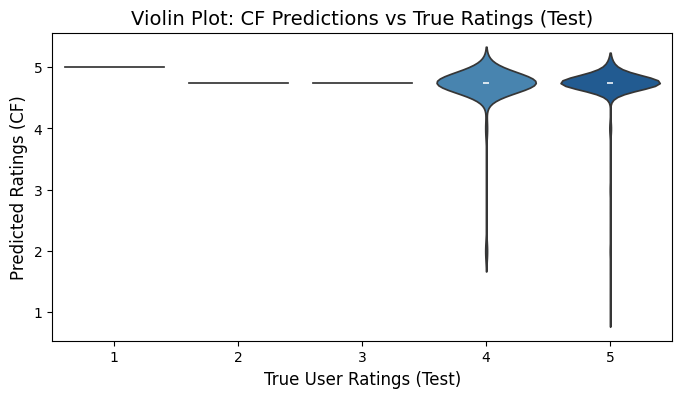

In [ ]:
plt.figure(figsize=(8, 4))
sns.violinplot(
    data=cf_predictions_df,
    x='true_rating',
    y='predicted_rating',
    palette='Blues'
)
plt.xlabel("True User Ratings (Test)", fontsize=12)
plt.ylabel("Predicted Ratings (CF)", fontsize=12)
plt.title("Violin Plot: CF Predictions vs True Ratings (Test)", fontsize=14)
plt.show()

The violin plot here clearly demonstrates a bias in the distributions towards reviews with high values.  This is likely because to mitigate the Cold Start Problem, we mandated that users of this Collaborative Filtering system had at least 5 interactions (ratings) with the system.  Considering that the mean number of ratings left by a user is 2, this means the workable dataset lost a lot of users, and biased towards the ones that are happy with following recipes and score them highly.

Secondly, there is intuition behind the absence of negative reviews: the most severe negative reviewers tend to only leave reviews when their experience was negative, exemplifying the bias from the original recipes dataset.

As for the distribution itself, it is extremely concentrated (low variance) for both the 4 and 5 star ratings, though their means are approximately equal, meaning that the sparsity of available data has made it difficult for collaborative filtering to be maximally effective.

### Implicit Recommender (Collaborative Filtering Follow-Up)

Associating rating with a positive or negative inclination from the user, hence the feedback is implicit and binary (1 or 0) rather than being an explicit ?/5 stars rating.  This builds off of the above collaborative filtering model.

In [ ]:
# Convert explicit feedback into binary implicit feedback, effectively it is now implicit, aka based on some vague interaction
df_implicit = df_reduced.copy()

df_implicit['engagement'] = (df_implicit['stars'] >= 4).astype(int) # positive vs negative interactions instead of stars

train_imp, test_imp = train_test_split(df_implicit, test_size=0.2, random_state=42)

print("Train size (implicit):", len(train_imp))
print("Test size (implicit): ", len(test_imp))

Train size (implicit): 1412
Test size (implicit):  353


In [ ]:
implicit_popularity_df = (
    train_imp
    .groupby('recipe_code')
    .agg({'engagement': 'sum'})
    .sort_values(by='engagement', ascending=False)
)

implicit_popularity_df.head()

,engagement
recipe_code,
3309,43
14299,42
2832,42
17826,28
100276,28


In [ ]:
def implicit_popular_predict(recipe_code):
    """
    Returns how many times 'recipe_code' was positively engaged with (>=4 rating)
    according to the TRAIN set. defaults to 0 if not in training data.
    """
    if recipe_code in implicit_popularity_df.index:
        return implicit_popularity_df.loc[recipe_code, 'engagement']
    else:
        return 0


In [ ]:
predicted_scores = []
for row in test_imp.itertuples(index=False):
    # row => user_id, recipe_code, stars, engagement, etc.
    user_id = row.user_id
    recipe  = row.recipe_code
    true_r  = row.stars
    # keep the star rating as well for reference.

    pred_score = implicit_popular_predict(recipe)
    predicted_scores.append((user_id, recipe, true_r, pred_score))

implicit_predictions_df = pd.DataFrame(
    predicted_scores,
    columns=['user_id', 'recipe_code', 'true_rating', 'predicted_engagement']
)

implicit_predictions_df.head()

,user_id,recipe_code,true_rating,predicted_engagement
0,u_1oKVa2JLGywqMhph6wvQOMKzSTR,4444,5,10
1,u_1oKVaIrsWHkFypYnwYxZt7cJSKH,21444,5,23
2,u_1oKVcUfQAMSIxzGPlb73FSMdW2t,18341,5,12
3,u_1oKVlSUIbWEOUoajBNtwpsR6ElO,1196,5,12
4,u_1oKVdbeyIGYYyoSvg3YzfUKSM7B,11588,5,12


<ipython-input-42-03b464f7fdb7>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(


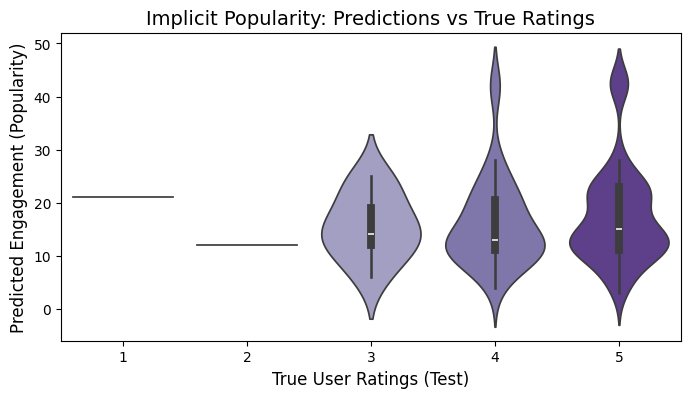

In [ ]:
fig, ax = plt.subplots(figsize=(8, 4))
sns.violinplot(
    data=implicit_predictions_df,
    x="true_rating",
    y="predicted_engagement",
    palette="Purples"
)

ax.set_xlabel("True User Ratings (Test)", fontsize=12)
ax.set_ylabel("Predicted Engagement (Popularity)", fontsize=12)
ax.set_title("Implicit Popularity: Predictions vs True Ratings", fontsize=14)

plt.show()

Evidently, the distributions indicate that when we can only go off of implicit feedback (such as estimates for whether something is likely to be seen as positive or negative for a specific user) the results aren't as accurate.  The three most populated of these distributions have a similar level of engagement and same shape / standard deviation, which does not follow the observed reality (that most 5 star recipes have a much higher level of engagement than the rest).

Alternatively but less likely, this may reveal that regardless of the scoring that users gave to recipes, they interact with all receipes mostly uniformly.

### Evaluating and Comparing the Recommender Systems

In the prior sections, our aim was to implement demonstrations of each of the recommendation engines: random, popularity-based, Bayesian, collaborative filtering, and implicit, with respect to the recipes dataset.  

We still wanted to gauge the performance in an overall sense via graphing distributions and observing the correlation between predicted ratings for all user-recipe combinations as compared to the true rating (via violin plots).  

However, this was preliminary testing and multiple evaluation metrics remain to be anaylzed...

This will cover this evaluation methodology including the familiar industry-standard metrics to assess performance:  

- Root Mean Squared Error (RMSE) penalize large errors heavily  
- Mean Absolute Error (MAE) measure net estimate error  
- Precision@K and Recall@K (for implicit feedback) accuracy and quality metrics for rankings
- Coverage, Personalization, and Diversity as metrics that should be moderated / balanced

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

def evaluate_explicit(predictions_df, model_name="Model"):
    # predictions_df must have columns: ['true_rating', 'predicted_rating'].
    rmse = np.sqrt(mean_squared_error(predictions_df['true_rating'], predictions_df['predicted_rating']))
    mae = mean_absolute_error(predictions_df['true_rating'], predictions_df['predicted_rating'])

    print(f"=== {model_name} ===") # Formatting
    print(f"RMSE: {rmse:.4f}")
    print(f"MAE : {mae:.4f}\n")


In [ ]:
evaluate_explicit(random_predictions_df, model_name="Random Recommender")
evaluate_explicit(popular_predictions_df, model_name="Popularity Recommender")
evaluate_explicit(bayesian_predictions_df, model_name="Bayesian Recommender")
evaluate_explicit(cf_predictions_df, model_name="User-Based CF") # Calculate for all relevant models

=== Random Recommender ===
RMSE: 0.8905
MAE : 0.5717

=== Popularity Recommender ===
RMSE: 0.7315
MAE : 0.4409

=== Bayesian Recommender ===
RMSE: 0.7297
MAE : 0.4412

=== User-Based CF ===
RMSE: 0.6515
MAE : 0.4250



**Observations**

*Random*:

As we initially noted, due to this dataset's overwhelmingly high-rating recipes, and lack of dislike for the vast majority of recipes (everyone is easily satisfied), the Root Mean Squared Error was mitigated, 0.8905.  The intuition is that a random Gamma distribution, centered at 4-5 stars can usually accidentally guess close to a 5 (which is close to the true value for most recipes).  The same goes for Mean Absolute Error, 0.5717, which is less affected by outlier recipe predicted ratings.

*Popular*:

Popularity: A notable ~0.1 reduction in both measures of error, suggesting that though it is unpersonalized, recommending the best-liked products reduces the stochastic risk of giving an unlucky user a recipe they dislike.  The minimization of these cases explains the RMSE of 0.7315 and MAE of 0.4409.

*Bayesian*:

An RMSE of 0.7297 which is an incremental improvement over the more naive popular algorithm, which did not penalize items with few reviews.  The MAE is slightly higher although still extremely close, at 0.4412.

*User-Based Collaborative Filtering*

An RMSE of 0.6515 and an MAE equal to 0.4250 are both notable improvements over the other algorithms, clearly including personalization yields the minimized errors of all these recommenders.  The predictions are more tailored and drastically reduce the issue of misrecommending a user a recipe.  Even though the dataset is overwhelmingly skewed via the dominant 5 star reviews for most recipes, personalization still offers benefits.

In [ ]:
def precision_k(pred_scores, true_labels, k=10):
    """
    pred_scores: 1D array-like of predicted scores for a single user (descending is better).
    true_labels: 1D array-like of ground truth binary (0 or 1) for that user.
    """
    # Indices of items sorted by predicted score (descending)
    top_k_indices = np.argsort(pred_scores)[::-1][:k]
    hits = sum(true_labels[top_k_indices])
    return hits / k

def recall_k(pred_scores, true_labels, k=10):
    top_k_indices = np.argsort(pred_scores)[::-1][:k]
    hits = sum(true_labels[top_k_indices])
    total_positives = sum(true_labels)
    return hits / total_positives if total_positives > 0 else 0

def evaluate_implicit(implicit_df, k=5):
    """
    For each user, rank items by predicted_engagement, then compute precision@k & recall@k.
    implicit_df has: ['user_id', 'recipe_code', 'true_rating', 'predicted_engagement'] plus an actual binary label.

    1) Convert true_rating -> actual binary engagement (test_engagement).
    2) Group by user and evaluate ranking metrics.
    """
    # 1) Convert to binary label for test data
    #    e.g. 1 if >=4 stars, else 0
    implicit_df['test_engagement'] = (implicit_df['true_rating'] >= 4).astype(int)

    precision_list = []
    recall_list = []

    # 2) Group test data by user
    user_groups = implicit_df.groupby('user_id')

    for user_id, group in user_groups:
        scores = group['predicted_engagement'].values  # predicted scores
        labels = group['test_engagement'].values       # ground truth (0 or 1)

        # If there aren't enough items, skip or handle carefully
        if len(scores) < k:
            continue

        p_k = precision_k(scores, labels, k=k)
        r_k = recall_k(scores, labels, k=k)

        precision_list.append(p_k)
        recall_list.append(r_k)

    mean_precision = np.mean(precision_list)
    mean_recall = np.mean(recall_list)

    print(f"Precision@{k}: {mean_precision:.4f}") # These metrics best apply to the implicit recommender, hence
    print(f"Recall@{k}:    {mean_recall:.4f}\n")


In [ ]:
evaluate_implicit(implicit_predictions_df, k=5)


Precision@5: 1.0000
Recall@5:    0.9375



These metrics are most relevant to an implicit recommender, where engagement such as a rating above for indicates a positive (+1) interaction, and anything less (or not leaving a rating) counts as a negative interaction (+0).

The key performance test here (to gauge this recommender's accuracy) is to rank each item for each user by predicted engagement (trained).  And then test what proportion of the items in a user's top 5 recommendations are indeed engaging for them (Precision@5).  Next, we determine what proportion of the truly engaging items that exist for a given user, were fetched by the recommender to them (Recall@5) by a recommendation set of size 5.

Notice that our precision was 100%, 1.0, meaning that every item recommended to a user in the top 5 was truly a positively associated one (in the test split).

Similarly, recall was very high at 0.9375 (93.75%), so we successfully covered the vast majority of the average user's implicitly positive engagements with a recommendation of 5 items.

These are very high and near perfect values, yielded from a a recommender that doesn't have perfect information, since it was further simplified (to be implicit) from the original metric of stars ratings.  This is because of the immense skew in the original dataset towards 5- (and a few 4-) star recommendations.

A supermajority of the recipes are rated as positive interactions by construction of this recommender, so any ranking with some vague intuition will have a good chance at capturing well-rated items, let alone a CF algorithm with some element of personalization.  Moreover, note that we mandated the dataset to only inlcude users with a minimum number of interactions (5) to avoid the cold start problem, reducing the size of the training and testing sets.

Hence it is still reasonable that for these conditions, the top-5 recommendations almost always alighn with recipes that have above 4 stars, and so the metric scores are near-perfect for Precision and Recall.

In [ ]:
def coverage_at_k(df, user_col='user_id', item_col='recipe_code', score_col='predicted_rating', k=5):
    # All unique items
    all_items = df[item_col].unique()
    all_items_count = len(all_items)

    recommended_items = set()

    # Group by user and get top-k items by predicted score
    for user_id, group in df.groupby(user_col):
        # Sort items for this user by descending predicted score
        sorted_group = group.sort_values(score_col, ascending=False)
        top_k_items = sorted_group.head(k)[item_col].values
        recommended_items.update(top_k_items)

    coverage_value = len(recommended_items) / all_items_count
    return coverage_value

def get_top_k_items(df, user_col='user_id', item_col='recipe_code', score_col='predicted_rating', k=5):
    """
    Returns a dictionary: user_id -> set of top-k item IDs, based on descending predicted score.
    - df: A DataFrame with columns [user_col, item_col, score_col].
    """
    user_topk = {}
    for user_id, group in df.groupby(user_col):
        sorted_group = group.sort_values(score_col, ascending=False)
        top_k_items = sorted_group.head(k)[item_col].unique()
        user_topk[user_id] = set(top_k_items)
    return user_topk

def personalization(user_topk_dict):
    # uses average Jaccard similarity across all pairs of users' top-k sets.
    user_ids = list(user_topk_dict.keys())
    n_users = len(user_ids)
    if n_users < 2:
        # only one user, there's nothing to compare
        return 1.0

    sim_sum = 0
    comparisons = 0
    for i in range(n_users):
        for j in range(i+1, n_users):
            set_i = user_topk_dict[user_ids[i]]
            set_j = user_topk_dict[user_ids[j]]

            intersection = len(set_i.intersection(set_j))
            union = len(set_i.union(set_j))
            jaccard_sim = intersection / union if union > 0 else 0
            sim_sum += jaccard_sim
            comparisons += 1

    avg_sim = sim_sum / comparisons if comparisons else 0
    personalization_score = 1 - avg_sim
    return personalization_score

def item_similarity(itemA, itemB):
    return 0.0 if itemA == itemB else 1.0

def diversity_at_k(top_k_items):
    """
    average i,j dissimilarity of items in a single user's top-k set. helped by item_similarity(), returns 1 if recipes are different (by code), 0 if same.
    """
    if len(top_k_items) <= 1:
        return 1.0  # Trivial, can't compare pairs

    items_list = list(top_k_items)
    pairwise_distances = []
    for i in range(len(items_list)):
        for j in range(i+1, len(items_list)):
            dist = item_similarity(items_list[i], items_list[j])
            pairwise_distances.append(dist)

    return np.mean(pairwise_distances)

def avg_diversity(df, user_col='user_id', item_col='recipe_code', score_col='predicted_rating', k=5):
    user_groups = df.groupby(user_col)
    div_values = []

    for user_id, group in user_groups:
        sorted_group = group.sort_values(score_col, ascending=False)
        top_k_items = sorted_group.head(k)[item_col].unique()
        div_values.append(diversity_at_k(top_k_items))

    if len(div_values) == 0:
        return 0.0

    return np.mean(div_values)

In [ ]:
print("== Random ==")
cov_random = coverage_at_k(
    random_predictions_df,
    user_col='user_id',
    item_col='recipe_code',
    score_col='predicted_rating',
    k=5
)
print(f"Coverage@5: {cov_random:.2%}")

random_topk_dict = get_top_k_items(
    random_predictions_df,
    user_col='user_id',
    item_col='recipe_code',
    score_col='predicted_rating',
    k=5
)
pers_random = personalization(random_topk_dict)
print(f"Personalization@5 (Random): {pers_random:.4f}")

random_diversity = avg_diversity(
    random_predictions_df,
    k=5
)
print(f"Diversity@5 (Random): {random_diversity:.4f}")

print()
print("== Popular ==")
cov_pop = coverage_at_k(
    popular_predictions_df,
    user_col='user_id',
    item_col='recipe_code',
    score_col='predicted_rating',
    k=5
)
print(f"Coverage@5 (Popular): {cov_pop:.2%}")

pop_topk_dict = get_top_k_items(
    popular_predictions_df,
    user_col='user_id',
    item_col='recipe_code',
    score_col='predicted_rating',
    k=5
)
pers_pop = personalization(pop_topk_dict)
print(f"Personalization@5 (Popular): {pers_pop:.4f}")

pop_diversity = avg_diversity(
    popular_predictions_df,
    k=5
)
print(f"Diversity@5 (Popular): {pop_diversity:.4f}")


print()
print("== Bayesian Popular ==")
cov_bayes = coverage_at_k(
    bayesian_predictions_df,
    user_col='user_id',
    item_col='recipe_code',
    score_col='predicted_rating',
    k=5
)
print(f"Coverage@5 (Bayesian): {cov_bayes:.2%}")

bayes_topk_dict = get_top_k_items(
    bayesian_predictions_df,
    user_col='user_id',
    item_col='recipe_code',
    score_col='predicted_rating',
    k=5
)
pers_bayes = personalization(bayes_topk_dict)
print(f"Personalization@5 (Bayesian): {pers_bayes:.4f}")

bayes_diversity = avg_diversity(
    bayesian_predictions_df,
    k=5
)
print(f"Diversity@5 (Bayesian): {bayes_diversity:.4f}")

print()
print("== Colaborative Filtering ==")
cov_cf = coverage_at_k(
    cf_predictions_df,
    user_col='user_id',
    item_col='recipe_code',
    score_col='predicted_rating',
    k=5
)
print(f"Coverage@5 (CF): {cov_cf:.2%}")

cf_topk_dict = get_top_k_items(
    cf_predictions_df,
    user_col='user_id',
    item_col='recipe_code',
    score_col='predicted_rating',
    k=5
)
pers_cf = personalization(cf_topk_dict)
print(f"Personalization@5 (CF): {pers_cf:.4f}")

cf_diversity = avg_diversity(
    cf_predictions_df,
    k=5
)
print(f"Diversity@5 (CF): {cf_diversity:.4f}")

print()
print("== Implicit ==")
cov_implicit = coverage_at_k(
    implicit_predictions_df,
    user_col='user_id',
    item_col='recipe_code',
    score_col='predicted_engagement',
    k=5
)
print(f"Coverage@5 (Implicit): {cov_implicit:.2%}")

implicit_topk_dict = get_top_k_items(
    implicit_predictions_df,
    user_col='user_id',
    item_col='recipe_code',
    score_col='predicted_engagement',
    k=5
)
pers_implicit = personalization(implicit_topk_dict)
print(f"Personalization@5 (Implicit): {pers_implicit:.4f}")


== Random ==
Coverage@5: 100.00%
Personalization@5 (Random): 0.9864
Diversity@5 (Random): 1.0000

== Popular ==
Coverage@5 (Popular): 100.00%
Personalization@5 (Popular): 0.9864
Diversity@5 (Popular): 1.0000

== Bayesian Popular ==
Coverage@5 (Bayesian): 100.00%
Personalization@5 (Bayesian): 0.9864
Diversity@5 (Bayesian): 1.0000

== Colaborative Filtering ==
Coverage@5 (CF): 100.00%
Personalization@5 (CF): 0.9846
Diversity@5 (CF): 1.0000

== Implicit ==
Coverage@5 (Implicit): 100.00%
Personalization@5 (Implicit): 0.9846


#### Reflection on Coverage, Personalization, and Diversity Metrics  

Across all the five recommenders, full (100%) coverage of the dataset was achieved.  This means that out of a possible 100 recipes (where roughly 20% of those--by review volume--are sampled for the test dataset), in all cases every recipe in the dataset appeared at least once in at least one user's top-5 recommendations (K=5).  This is only possible due to the few number of recipes comprising this dataset, and goes hand in hand wit h the diversity metric as well.

The Personalization metrics, for the five recommenders, again are similarly extremely high (at 98%).  This would mean that each user's recommendations (in the possibly small test pools), with K=5 contained very different and almost fully unique items.  This would make sense for a random recommender, even one that has a fixed distribution, however even the more "intelligent" recommenders: Popular, Bayesian, and the CF variants show high personalization--indicating high variance in user preference.  Recall that Personalization, while somewhat desired is not akin to a "perfect" recommender, as two similar users should not be treated as "unique" from one another.

Conversely, Diversity which is the individual scale variant of coverage, is perfectly correlated with 100% for all recommenders tested as well.  This implies that each user's top K recommended picks are as different as possible from each other.  This means similarity based clustering was not as effective as it could have been if a) users were more active and/or b) reviews were more varied.  

In total, these results seem peculiar and reflect the biased nature of the original dataset in having primarily positive reviews regardless of the recipe.  So engagement, due to being well distributed is also diversified, leading to user personalization, and in turn covering the full (but small) set of 100 recipes.